We are going to implement a classification algorithm with a Feed Forward Fully Connected Neural Network, also called Multi Layer Perceptron (MLP).  

In [55]:
%matplotlib inline  

import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import operator
import warnings
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split



warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
# this function takes col category and returns as Y (target), the other columns are X (labels)
def split_X_Y(data):
    Y = data['category']
    X = data.drop('category',axis=1)

    return X,Y

# this function divides the dataset in input in parts_to_be_split parts. One of them is returned as test_set
# the other ones are the training_set. Indexes of the chosen data can be accessed (test_indexes, train_indexes)
# (for example in a K-fold)

def split_train_test_set(data,parts_to_be_split):
    indexes = np.arange(0,data.shape[0],1)
    rnd.shuffle(indexes)
    len_test_set = int(len(indexes) / parts_to_be_split)

    test_indexes = indexes[:len_test_set]
    train_indexes = indexes[len_test_set:]

    train_set = data.iloc[train_indexes]
    test_set = data.iloc[test_indexes]
    
    return train_set, test_set

In [84]:
train_set, test_set = split_train_test_set(data,5)
X_train,Y_train = split_X_Y(train_set)
X_test,Y_test = split_X_Y(test_set)
Y_train = np.array(np.where(Y_train == 'g', 1, -1))
Y_test  = np.array(np.where(Y_test == 'g', 1, -1))

print('shape of train_set:',np.shape(X_train),np.shape(Y_train))
print('shape of train_set:',np.shape(X_test),np.shape(Y_test))
print(X_train,Y_train)


shape of train_set: (15216, 10) (15216,)
shape of train_set: (3803, 10) (3803,)
       fLength   fWidth   fSize   fConc  fConc1    fAsym  fM3Long  fM3Trans  \
87     41.0677  16.2578  2.7308  0.3532  0.1812  47.4405  37.9125   16.1237   
6218   21.1472   6.4262  2.1917  0.7717  0.5113 -18.8597 -16.9767    6.2189   
2239   86.3172  27.7342  3.3879  0.1887  0.1091 -72.2713 -53.3688   21.5520   
16799  22.3881   7.9780  2.2882  0.6418  0.3604 -12.9964  -4.4094   -3.9880   
13090  33.7758  18.1018  2.7945  0.2905  0.1581   5.4566 -21.1754  -11.6431   
...        ...      ...     ...     ...     ...      ...      ...       ...   
17932  23.0916   8.9710  2.4108  0.6175  0.4291   9.7476   9.2490   -6.5998   
13148  31.1555  12.3874  2.6597  0.4183  0.2364  -7.1292  27.3118   -0.4479   
1020   30.8252  10.7739  2.4040  0.4852  0.2623 -40.6069 -16.8903  -11.7654   
9140   53.0719  22.5881  2.9467  0.2973  0.1668  32.0257  53.2193  -17.9499   
5187   31.8057  21.1941  2.8985  0.3007  0.1598  35

We choose the RELU activation function for the hidden layers (most frequent choice) and the Stochastic Gradient Descent method to compute the weights with Backpropagation. Thus, the hyper-parameters of the hypothesis class we have to tune are the **architecture of the network** (number of hidden layers and neurons in each hidden layer) and the **learning rate**. We implement a grid search to find the combination of these parameters that maximizes the partial area under the ROC curve, up until a false positive rate FPR $\le$ 0.2.      

In [ ]:
parameters = {'hidden_layer_sizes': [(18,), (36,), (54), (36,18), (54,18), (54,36), (54,36,18)],'learning_rate_init': [0.1,0.01,0.001]}

MLP=MLPClassifier(activation = 'relu', max_iter = 300, alpha = 1e-4, solver = 'sgd',tol = 1e-4, learning_rate = 'adaptive')

# this function determines the partial area under the curve, up to FPR<=0.2
def partial_auc_at_fpr(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    valid_indices = fpr <= 0.2  # indices where FPR <= 0.2
    partial_fpr = fpr[valid_indices]
    partial_tpr = tpr[valid_indices]
    # check if there are at least 2 points for partial AUC calculation
    if len(partial_fpr) < 2:
        return 0  # return 0 if not enough points to calculate AUC

    partial_auc = auc(partial_fpr, partial_tpr)
    return partial_auc

# create scoring function (partial AUC) to implement a grid-search
partial_auc_scorer = make_scorer(partial_auc_at_fpr, greater_is_better=True)

# to print the results after each combination is evaluated
class VerboseGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        super()._run_search(evaluate_candidates)
        
        # print the partial AUC after each parameter evaluation
        for i, params in enumerate(self.cv_results_['params']):
            mean_score = self.cv_results_['mean_test_score'][i]
            print(f"Parameters: {params} - Partial AUC: {mean_score}")

# implement the grid-search to maximize the partial AUC (5-fold cross-validation)
grid_search = VerboseGridSearchCV(estimator=MLP, param_grid=parameters, scoring=partial_auc_scorer, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_,)
print("Best partial AUC (Training set):", grid_search.best_score_)

# evaluate the best model on the test set and plot its ROC curve
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[fpr <= 0.2]
test_partial_auc = auc(partial_fpr, partial_tpr)
print("Best partial AUC (Test set):", test_partial_auc)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
print(models.best_params_['hidden_layer_sizes'])

best_model=MLPClassifier(activation = 'relu', hidden_layer_sizes = models.best_params_['hidden_layer_sizes'], learning_rate_init=models.best_params_['learning_rate_init'], max_iter = 200, alpha = 1e-4, solver = 'sgd',tol = 1e-4, learning_rate = 'adaptive')
best_model.fit(X_train,Y_train)
best_pred = best_model.predict(X_test)
accuracy = skm.accuracy_score(Y_test, best_pred)


(32,)
['h' 'g' 'g' 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'h' 'g' 'g' 'g' 'h' 'g' 'g' 'g'
 'g' 'h' 'g' 'g' 'g' 'h' 'g' 'h' 'g' 'h' 'h' 'g' 'g' 'g' 'g' 'g' 'h' 'g'
 'g' 'g' 'g' 'g' 'g' 'g' 'g' 'g' 'h' 'g' 'h' 'h' 'g' 'g' 'h' 'g' 'h' 'h'
 'h' 'g' 'g' 'h' 'g' 'h' 'g' 'g' 'h' 'h' 'g' 'g' 'g' 'h' 'g' 'g' 'h' 'g'
 'g' 'g' 'h' 'g' 'h' 'g' 'g' 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'g' 'g' 'g' 'h'
 'g' 'g' 'g' 'g' 'g' 'g' 'g' 'h' 'g' 'h' 'h' 'g' 'g' 'h' 'g' 'h' 'g' 'g'
 'g' 'g' 'h' 'g' 'g' 'g' 'h' 'g' 'g' 'h' 'g' 'h' 'h' 'g' 'g' 'g' 'g' 'g'
 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'g' 'g' 'g' 'g' 'h' 'g'
 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'h' 'g' 'h' 'g'
 'g' 'g' 'h' 'g' 'h' 'g' 'g' 'h' 'g' 'h' 'g' 'h' 'h' 'g' 'g' 'g' 'g' 'h'
 'g' 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'g' 'g' 'g' 'h' 'g' 'g' 'h' 'g' 'g' 'g'
 'g' 'g']


Neural network Q factor: 2.28


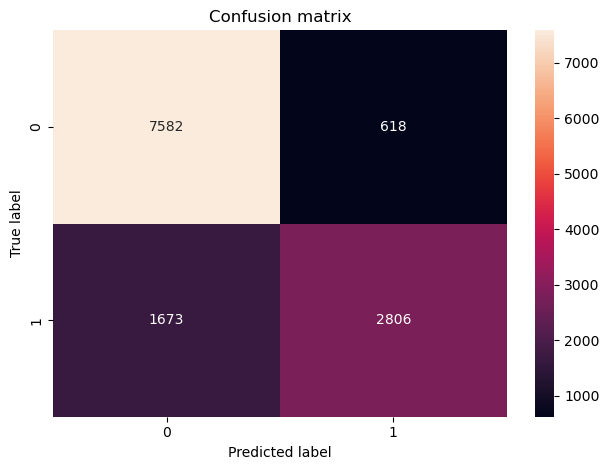

In [49]:
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    sns.heatmap(conf_matrix, annot=True, fmt="d",)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

labels, freqs = np.unique(Y_test, return_counts=True) 
cm_NN = skm.confusion_matrix(Y_test, best_pred)
print(f'Neural network Q factor: {betsNN_Q:.2f}')
plot_conf_matrix(cm_NN)
